In [10]:
import random
import torch
import torch.utils.data as data_utils
from data.torchfsdd.dataset import TorchFSDDGenerator
from data.augmentations.randphase import AllPassFilter
from torch_audiomentations import *

In [11]:
# import glob
# glob.glob('/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings/*.wav')

In [12]:
from models.pqmf import PQMF

# Initialize augmentation callable
audio_augmentation = Compose(
    p=0.5,
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.1,
            sample_rate = 8000,
            output_type='dict'
        ),
        # PitchShift(p=0.05, p_mode='per_example',
        #     sample_rate = 8000,
        #     output_type='dict'),
        AddColoredNoise(p=1,
            min_snr_in_db = 5,
            max_snr_in_db = 15,
            sample_rate = 8000),
        Shift(-0.05, 0.2, p=0.1,
            sample_rate = 8000,
            output_type='dict'),
        PolarityInversion(p=0.1,
            sample_rate = 8000,
            output_type='dict'),
        AllPassFilter(sample_rate=8000,
            output_type='dict')
    ], output_type='dict'
)
pqmf = PQMF(100, 2)
transform = lambda x: pqmf(audio_augmentation(x)['samples'])

# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(version='local', 
                        path='/home/theloni/audio-rc-rtl/exploration/data/torchfsdd/recordings',
                        train_transforms=transform,
                        val_transforms=pqmf)

train_set, test_set, val_set  = fsdd.train_val_test_split(test_size=0.05, val_size=0.1)
len(train_set), len(test_set), len(val_set)

/home/theloni/miniconda/envs/iir-torch/lib/python3.11/site-packages/torch_audiomentations/core/transforms_interface.py:77: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = AddColoredNoise(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  warnings.warn(


2999


(2534, 297, 148)

In [147]:
#TODO: add extra labels for noise and silence, and add randomly in the dataloader
NOISE_PROB = 0.025
SILENCE_PROB  = 0.025
SILENCE_EPS = 1e-4
b_rms = lambda x: x.pow(2).mean(dim = -1).mean(dim=-1).sqrt()
def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences,  labels = [], torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        labels[i] = label
        seq = sequence
        dice = random.random()
        if dice < NOISE_PROB:
            labels[i] = 11
            seq = pqmf(b_rms(seq).unsqueeze(-1).unsqueeze(-1) * torch.randn(seq.shape[0], 1, pqmf.n_band * seq.shape[-1]))
        if dice > NOISE_PROB and dice < NOISE_PROB + SILENCE_PROB:
            labels[i] = 12
            seq = pqmf(SILENCE_EPS * torch.randn(seq.shape[0], 1, pqmf.n_band * seq.shape[-1]))
        sequences.append(seq)

    # Combine sequences into a padded matrix
    stacked_sequences = torch.cat(sequences, dim=0)#torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x T_max x D)

    return stacked_sequences, labels
    # Shapes: (B x T_max x D), (B,), (B,)


In [148]:
train_gen = data_utils.DataLoader(train_set, collate_fn=collate_fn, batch_size=64, shuffle=True, pin_memory=True)
val_gen = data_utils.DataLoader(val_set, collate_fn=collate_fn, batch_size=len(val_set))
test_gen = data_utils.DataLoader(test_set, collate_fn=collate_fn, batch_size=len(test_set))

In [149]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [150]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate, NFFT=128, noverlap=64)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


In [151]:
sample_batch, labels = next(iter(train_gen))
sample_batch.shape, labels.shape

(torch.Size([64, 2, 4032]), torch.Size([64]))

In [152]:
labels

tensor([ 6,  3,  3,  0,  6,  4,  5,  2,  9,  0,  8,  8,  7,  8,  2,  0,  2,  8,
         8,  6,  3,  9,  8,  7,  8,  9,  7, 11,  6,  8,  6,  1,  9,  5,  6, 12,
         2,  5,  2,  7,  7,  6,  1,  1,  1,  1,  4,  0,  0,  6,  1,  4,  2,  1,
        12,  2,  8,  5,  9,  6,  7,  5,  1,  6])

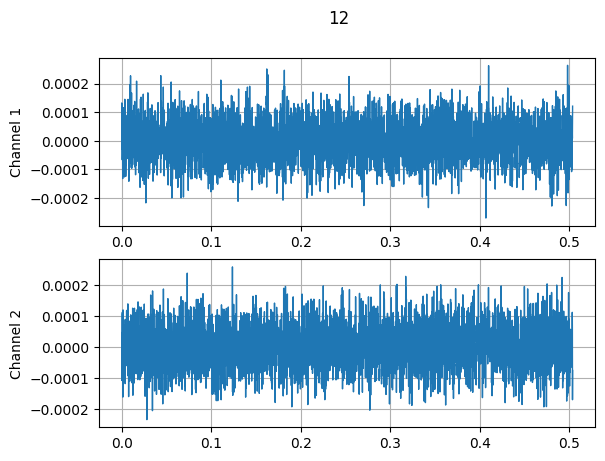

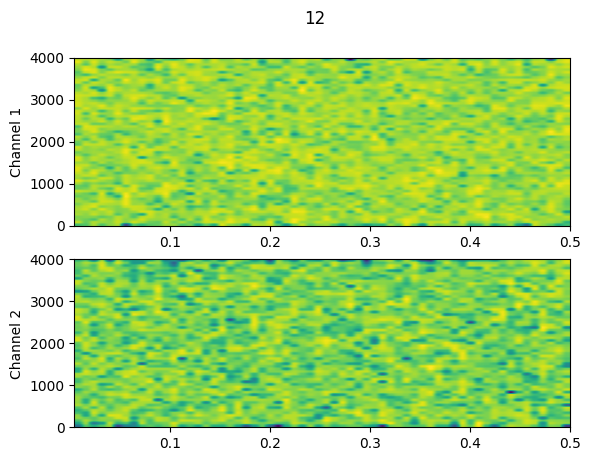

In [153]:
idx = (labels == 12).int().argmax()#random.randint(0,sample_batch.shape[0]-1)
waveform = sample_batch[idx]
label = labels[idx]
sample_rate = 8000
plot_waveform(waveform, sample_rate, title=label.item())
plot_specgram(waveform, sample_rate, title=label.item())
play_audio(waveform, sample_rate)